In [1]:
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.nn import DynamicEdgeConv, global_max_pool,global_mean_pool,knn_graph,MessagePassing
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

In [14]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,Z_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        Z_layers_all = np.vstack((Z_layers_all, np.vstack(Z_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, Z_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        Z_layers_all = np.vstack((Z_layers_all, Z_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    Z_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        posZ = pos_z[i_event].to_numpy()
        Z_layers_event = np.bincount(layers, weights=posZ*energies, minlength=ECAL_layers)
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        Z_layers.append(Z_layers_event/E_layers_event.clip(min=1e-6))
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,Z_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, Z_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_la

length after zero suppression: 1249703 1249703 1249703 1249703 1249703 1249703
length after event selection: 1249703
length after zero suppression: 59990 59990 59990 59990 59990 59990
length after event selection: 59990
length of E_truth_test: 59990


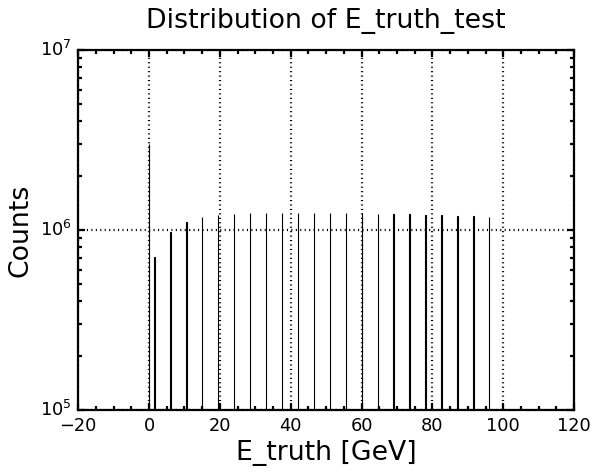

length after event selection: 59990 59990 59990 59990 59990 59990


In [15]:
#zero suppression
def zero_suppression(E_layers, N_layers, Z_layers, E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    Z_sum = np.array([np.sum(z) for z in Z_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]
    Z_layers_filtered = [Z_layers[i] for i in range(len(Z_layers)) if mask[i]]
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(Z_layers_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, Z_layers_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,Z_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth = zero_suppression(E_layers, N_layers, Z_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    Z_layers = np.array([start_from_shower_layer(ev) for ev in Z_layers])
    print("length after event selection:", len(E_layers))
    return E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, Z_layers_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, Z_layers_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, Z_layers_test, E_truth_test)
#Draw E_truth
print("length of E_truth_test:", len(E_truth_test))
plt.figure(figsize=fig_size)
plt.hist(Z_layers_uniform.flatten(), bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
print("length after event selection:", len(E_layers_test), len(N_layers_test), len(E_sum_test), len(N_sum_test), len(Z_layers_test), len(E_truth_test))

In [16]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [17]:
def make_event_graph_list(E_layers, N_layers, Z_layers, y_true, extra_features=None, k=3):
    n_events, n_nodes = E_layers.shape
    data_list = []
    for i in range(n_events):
        x_node_features = torch.tensor(
            list(zip(E_layers[i], N_layers[i], Z_layers[i])),
            dtype=torch.float32
        )
        z_coords = x_node_features[:, 2].view(-1, 1)
        edge_index = knn_graph(z_coords, k=k, loop=False)
        label = torch.tensor(y_true[i], dtype=torch.float32)
        extra = None
        if extra_features is not None:
            extra = torch.tensor(extra_features[i], dtype=torch.float32).view(1, -1)
        data = Data(
            x=x_node_features,
            edge_index=edge_index,
            y=label,
            extra=extra
        )
        data_list.append(data)
    return data_list

def get_batch_size(device):
    if device.type == "cuda":
        total_mem = torch.cuda.get_device_properties(device).total_memory / (1024**3)  # GB
        if total_mem < 8:
            return 256
        elif total_mem < 16:
            return 1024
        else:
            return 2048
    else:
        return 128  
Xextra_train = np.hstack([
    #E_layers_uniform, 
    #N_layers_uniform,
    #Z_layers_uniform,
    #E_layers_uniform_ratio,
    E_sum_uniform[:, np.newaxis],
    #N_layers_uniform_ratio,
    N_sum_uniform[:, np.newaxis],
    E_N_layers_uniform,
    #LayerNum_uniform[:, np.newaxis],
    #Average_E_layer_uniform[:, np.newaxis],
    #Average_N_layer_uniform[:, np.newaxis],
])
Xextra_test = np.hstack(
    [#E_layers_test, 
    #N_layers_test,
    #Z_layers_test, 
    #E_layers_test_ratio,
    E_sum_test[:,np.newaxis], 
    #N_layers_test_ratio,
    N_sum_test[:,np.newaxis],
    E_N_layers_test,
    #LayerNum_test[:, np.newaxis],
    #Average_E_layer_test[:, np.newaxis],
    #Average_N_layer_test[:, np.newaxis],
])
y_train_true = E_truth_uniform
y_test_true = E_truth_test
KNN_K=3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = get_batch_size(device)
data_list_train = make_event_graph_list(
    E_layers=E_layers_uniform,
    N_layers=N_layers_uniform,
    Z_layers=Z_layers_uniform,                            # 单独传 Z
    y_true=y_train_true,
    k=KNN_K,
    extra_features=None,                            # 传入额外特征
)
data_list_test  = make_event_graph_list(
    E_layers=E_layers_test,
    N_layers=N_layers_test,
    Z_layers=Z_layers_test,                               # 单独传 Z
    y_true=y_test_true,
    k=KNN_K,
    extra_features=None,                            # 传入额外特征
)

all_node_features = torch.cat([d.x for d in data_list_train], dim=0).numpy()
scaler = StandardScaler().fit(all_node_features)

for d in data_list_train + data_list_test:
    d.x = torch.tensor(scaler.transform(d.x), dtype=torch.float32)
val_split = 0.2
data_list_train, data_list_val = train_test_split(data_list_train, test_size=val_split, random_state=random_state)


In [18]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        denom = torch.clamp(y_true + self.eps, min=1e-6)
        ratio = y_pred / denom
        ratio = torch.clamp(ratio, min=-0.99)  # 保证 log1p 有效
        log = torch.log1p(ratio)
        square = torch.square(ratio)
        abs_log = torch.abs(log)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.activation(x)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.BatchNorm1d(input_dim))
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)
    
class DGCNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.linear = nn.Linear(2*in_channels, out_channels)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, edge_index):
        row, col = edge_index
        x_i, x_j = x[row], x[col]
        edge_feat = torch.cat([x_i, x_j], dim=1)
        out = x.new_zeros(x.size(0), self.linear.out_features)
        out.index_add_(0, row, self.linear(edge_feat))
        deg = torch.bincount(row, minlength=x.size(0)).clamp(min=1).view(-1,1)
        out = out / deg
        out = self.activation(out)
        out = self.dropout(out)
        return out

class DGCNNBlock(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64,128], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"DGCNNBlock: input_dim={input_dim}, hidden_dims={hidden_dims}, dropout={dropout}, activation={activation}")
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(DGCNNLayer(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.layers = nn.ModuleList(layers)
    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)
        return x

class DGCNN_MLP(nn.Module):
    def __init__(self, input_dim=3, dg_hidden=[64,128], mlp_hidden=[128,64,32], extra_dim=0, dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.activation = activation
        self.dgcnn = DGCNNBlock(input_dim=input_dim, hidden_dims=dg_hidden, dropout=dropout, activation=activation)
        self.dg_out_dim = dg_hidden[-1]
        self.extra_dim = extra_dim
        self.mlp = MLPRegressor(input_dim=self.dg_out_dim + self.extra_dim, hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.dgcnn(x, edge_index)
        pooled = global_mean_pool(x, getattr(data, 'batch', None)) if hasattr(data,'batch') else x.mean(dim=0,keepdim=True)
        if hasattr(data,'extra') and data.extra is not None:
            combined = torch.cat([pooled, data.extra], dim=-1)
        else:
            combined = pooled
        return self.mlp(combined)
    


In [19]:
def train_dgcnn(data_list_train,data_list_val,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
              dg_dims=[32, 64, 128], 
              mlp_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=3,
              patience=10,
              val_split=0.2,
              random_state=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(data_list_train)}, Validation samples: {int(len(data_list_val))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    train_loader = PyGDataLoader(data_list_train, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(data_list_val, batch_size=batch_size, shuffle=False)

    # Model
    model = DGCNN_MLP(
    input_dim=data_list_train[0].x.size(1),
    extra_dim=(data_list_train[0].extra.size(-1) if hasattr(data_list_train[0], "extra") else 0),
    dg_hidden=dg_dims,
    mlp_hidden=mlp_dims,
    dropout=dropout,
    activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = 2 * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs

        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            if (best_val_loss - val_loss) / best_val_loss > 0.01:
                patience_counter = 0
            best_val_loss = val_loss
            best_state_dict = model.state_dict()    
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    #
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred

Using device: cuda
Random state: 42
Training samples: 999762, Validation samples: 249941
learning rate: 0.0005, batch size: 2048, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
DGCNNBlock: input_dim=3, hidden_dims=[32, 64, 128], dropout=0.1, activation=PReLU(num_parameters=1)
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Epoch 001/50 | Train Loss: 0.029891 | Val Loss: 0.010236| LR: 0.000200
Epoch 002/50 | Train Loss: 0.005960 | Val Loss: 0.007142| LR: 0.000300
Epoch 003/50 | Train Loss: 0.004451 | Val Loss: 0.005279| LR: 0.000400
Epoch 004/50 | Train Loss: 0.003848 | Val Loss: 0.002927| LR: 0.000500
Epoch 005/50 | Train Loss: 0.003577 | Val Loss: 0.003273| LR: 0.000600
Epoch 006/50 | Train Loss: 0.003285 | Val Loss: 0.003827| LR: 0.000498
Epoch 007/50 | Train Loss: 0.002931 | Val Loss: 0.004289| LR: 0.000490
Epoch 008/50 | Train Loss: 0.002915 | Val Loss: 0.003144| LR: 0.000478
Epoch 009/50 | Train Loss: 0.002586 | Val Loss: 0.002913| LR: 0.

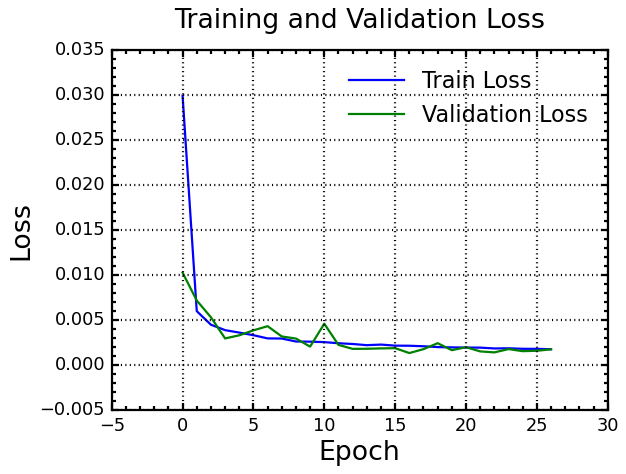

In [ ]:
dgcnn_model, y_val_true, y_val_pred = train_dgcnn(
    data_list_train,
    data_list_val,
    activation=nn.PReLU(),
    loss=HuberRelativeLoss(delta=0.05),
    dg_dims=[32, 64, 128],
    mlp_dims=[128, 64, 32],
    dropout=0.2,
    lr=5e-4,
    weight_decay=1e-4,
    batch_size=batch_size,
    epochs=50,
    patience=10,
    val_split=0.2,
    random_state=random_state
)
torch.save(dgcnn_model, DataPath_Validate+f"/Models/DGCNN.pth")
# Evaluate on test set

In [21]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (3, 10)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist_all = []

device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
test_loader = PyGDataLoader(data_list_test, batch_size=batch_size, shuffle=False)
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred, E_truth_test, Energy_test, Nbins=50)
Reco_hist_all.append(Reco_hist)

# fit_range = (0, 65) 
# mask = y_val_pred>0
# residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
# E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
# x_fit = np.linspace(fit_range[0], fit_range[1], 200)
# y_fit = E_calib_fit(x_fit)
# plt.figure(figsize=fig_size)
# plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
# #plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
# plt.plot(x_fit, y_fit, color='red', label='Fit')
# plt.xlabel("E_pred [GeV]")
# plt.ylabel("(E_pred - E_true)/E_pred")
# plt.title("Residual vs E_pred")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="lower right")
# plt.show()

# y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
# y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
# Reco_hist_all.clear()
# Reco_hist = build_reco_hist(y_test_pred_calib, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_all.append(Reco_hist)

# plt.figure(figsize=fig_size)
# plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
# plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
# plt.xlabel("E_truth [GeV]")
# plt.ylabel("E_pred [GeV]")
# plt.title("MLP Reconstructed Energy vs True Energy")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="upper left")  
# plt.show()


In [22]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_all: 1
length of Reco_hist: 12
Mean: 10.461004913115607, Peak: 10.671982765197754, RMS: 0.5978217423497528
Initial Gamma Fit Parameters: [np.float64(533.2624855041504), np.float64(4.912038837922193), np.float32(7.5244813), np.float64(0.5978217423497528)]
Gamma Fit Bounds: lower [np.float64(5.332624855041504), np.float64(-0.5087961162077808), np.float32(-0.24755186), np.float64(0.05978217423497528)], 
 upper [np.float64(3199.5749130249023), np.float64(49.12038837922193), np.float32(21.286722), np.float64(5.9782174234975285)]
Gamma Fit Parameters: [5.31212728e+02 4.91203884e+01 6.36125782e+00 8.44013344e-02]
Gamma Fit Peak: 10.422682816378398 ± 0.013022099210057494, Mean: 10.507084150818475 ± 0.013131503338675736, Resolution: 0.05675455040439429 ± 0.000863353835366664


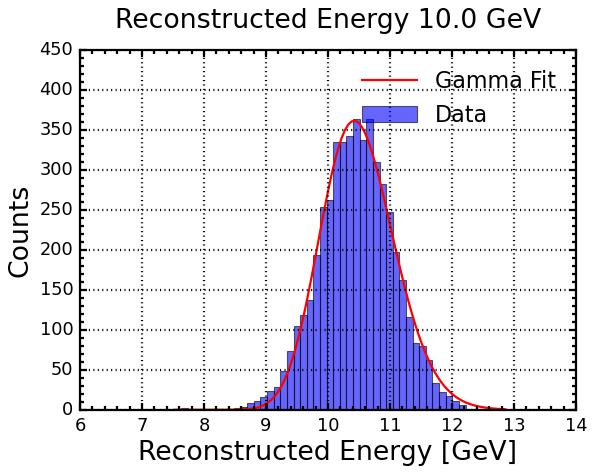

In [23]:
#This cell is left here for debug
print("length of Reco_hist_all:", len(Reco_hist_all))
Reco_hist = Reco_hist_all[0] # Example for first beta
print("length of Reco_hist:", len(Reco_hist))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist))
#print(Reco_hist[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])

Mean: 0.2075638415841147, Peak: 0.18774279952049255, RMS: 0.048555656292636896
Initial Gamma Fit Parameters: [np.float64(37.74003982543945), np.float64(2.9772598287803316), np.float32(0.06300104), np.float64(0.048555656292636896)]
Gamma Fit Bounds: lower [np.float64(0.37740039825439453), np.float64(-0.7022740171219668), np.float32(-0.9936999), np.float64(0.00485556562926369)], 
 upper [np.float64(226.44023895263672), np.float64(29.772598287803316), np.float32(10.0945015), np.float64(0.48555656292636895)]
Gamma Fit Parameters: [ 3.75143463e+01  2.97725983e+01 -4.43681757e-02  8.54011397e-03]
Gamma Fit Peak: 0.20135309287100858 ± 0.003033166407814637, Mean: 0.2098932068419888 ± 0.003075587765794599, Resolution: 0.23142684267294086 ± 0.011996353261484271


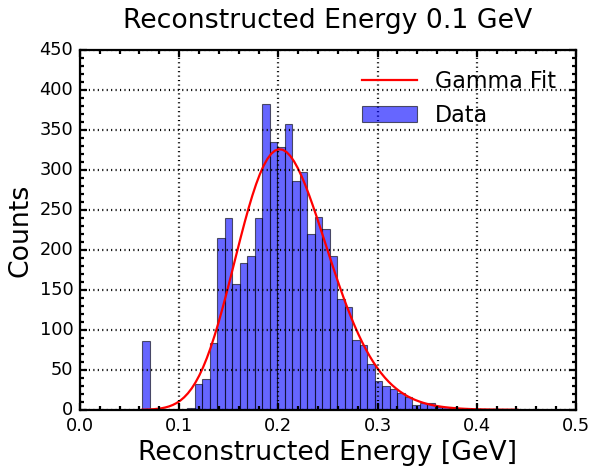

appending results for E = 0.1
Mean_Gamma: 0.2098932068419888 Mean_Gamma_Error: 0.003075587765794599
Peak_Gamma: 0.20135309287100858 Peak_Gamma_Error: 0.003033166407814637
Mean: 0.35688656098074145, Peak: 0.3334085941314697, RMS: 0.07575875700896625
Initial Gamma Fit Parameters: [np.float64(65.37680692970753), np.float64(3.851584025467764), np.float32(0.06509534), np.float64(0.07575875700896625)]
Gamma Fit Bounds: lower [np.float64(0.6537680692970753), np.float64(-0.6148415974532235), np.float32(-0.99349046), np.float64(0.007575875700896626)], 
 upper [np.float64(392.26084157824516), np.float64(38.51584025467764), np.float32(10.097643), np.float64(0.7575875700896626)]
Gamma Fit Parameters: [6.49336903e+01 1.42146240e+01 7.89547874e-02 1.94595294e-02]
Gamma Fit Peak: 0.33610515033810684 ± 0.001976631765957727, Mean: 0.3555646796911507 ± 0.0020360869772549843, Resolution: 0.21828548217160343 ± 0.0051478265577405286


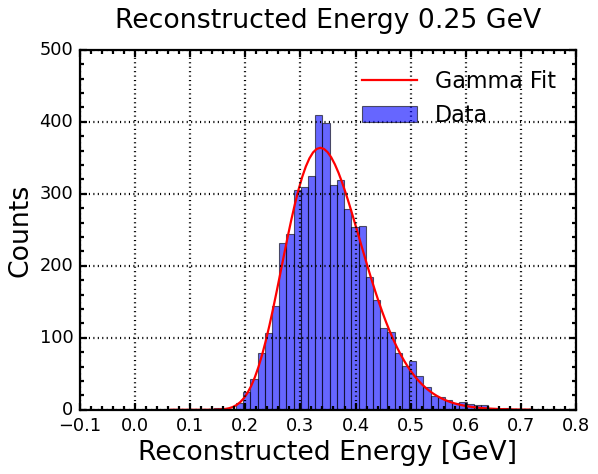

appending results for E = 0.25
Mean_Gamma: 0.3555646796911507 Mean_Gamma_Error: 0.0020360869772549843
Peak_Gamma: 0.33610515033810684 Peak_Gamma_Error: 0.001976631765957727
Mean: 0.5980004207754717, Peak: 0.5426592826843262, RMS: 0.13104499069811262
Initial Gamma Fit Parameters: [np.float64(116.59121552109718), np.float64(4.07155139958972), np.float32(0.064444005), np.float64(0.13104499069811262)]
Gamma Fit Bounds: lower [np.float64(1.165912155210972), np.float64(-0.592844860041028), np.float32(-0.9935556), np.float64(0.013104499069811263)], 
 upper [np.float64(699.5472931265831), np.float64(40.7155139958972), np.float32(10.096666), np.float64(1.3104499069811262)]
Gamma Fit Parameters: [1.16643319e+02 7.90970573e+00 2.29417215e-01 4.68062418e-02]
Gamma Fit Peak: 0.5528345719356957 ± 0.0021051915597070986, Mean: 0.5996408137479854 ± 0.0022254725480454, Resolution: 0.2381160891396167 ± 0.003800614697011899


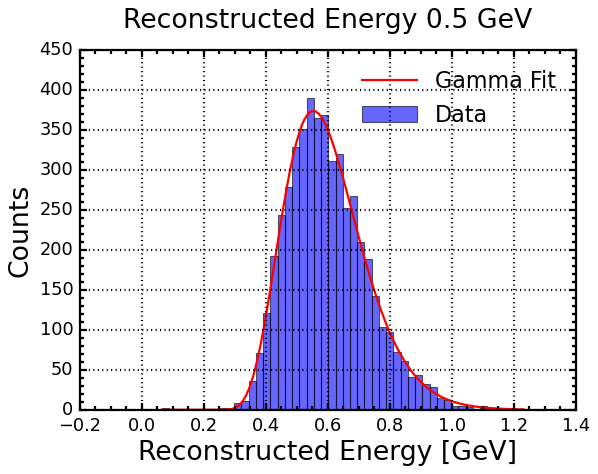

appending results for E = 0.5
Mean_Gamma: 0.5996408137479854 Mean_Gamma_Error: 0.0022254725480454
Peak_Gamma: 0.5528345719356957 Peak_Gamma_Error: 0.0021051915597070986
Mean: 1.1104006022810935, Peak: 1.090881109237671, RMS: 0.2150432157566402
Initial Gamma Fit Parameters: [np.float64(178.88113856315613), np.float64(3.8340424151105164), np.float32(0.2859158), np.float64(0.2150432157566402)]
Gamma Fit Bounds: lower [np.float64(1.7888113856315613), np.float64(-0.6165957584889483), np.float32(-0.9714084), np.float64(0.021504321575664023)], 
 upper [np.float64(1073.2868313789368), np.float64(38.34042415110516), np.float32(10.428874), np.float64(2.150432157566402)]
Gamma Fit Parameters: [1.78708418e+02 2.21358570e+01 9.46116713e-02 4.59988434e-02]
Gamma Fit Peak: 1.0668366495505919 ± 0.0043977392040839966, Mean: 1.1128354929517348 ± 0.004480795354229073, Resolution: 0.2028603431425105 ± 0.003340901005841211


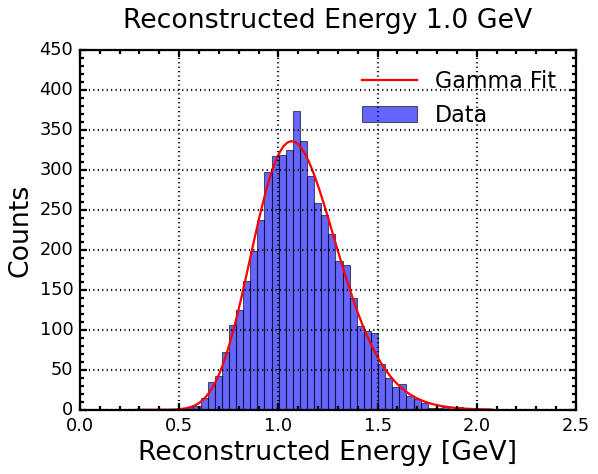

appending results for E = 1.0
Mean_Gamma: 1.1128354929517348 Mean_Gamma_Error: 0.004480795354229073
Peak_Gamma: 1.0668366495505919 Peak_Gamma_Error: 0.0043977392040839966
Mean: 2.194126331114769, Peak: 2.0935771465301514, RMS: 0.3126433062742792
Initial Gamma Fit Parameters: [np.float64(224.52056407928467), np.float64(3.122340470630873), np.float32(1.2179475), np.float64(0.3126433062742792)]
Gamma Fit Bounds: lower [np.float64(2.2452056407928467), np.float64(-0.6877659529369127), np.float32(-0.87820524), np.float64(0.03126433062742792)], 
 upper [np.float64(1347.123384475708), np.float64(31.223404706308727), np.float32(11.826921), np.float64(3.1264330627427923)]
Gamma Fit Parameters: [2.25518886e+02 3.12234047e+01 4.22388865e-01 5.72733976e-02]
Gamma Fit Peak: 2.153385938810907 ± 0.007441783219177334, Mean: 2.210659336395629 ± 0.00754160443122695, Resolution: 0.14861792843499688 ± 0.002602075566932541


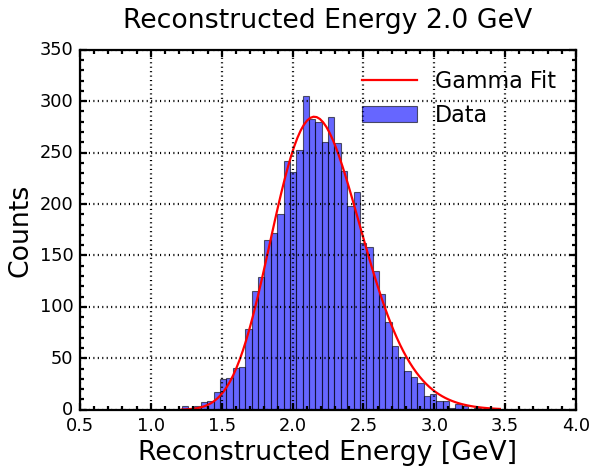

appending results for E = 2.0
Mean_Gamma: 2.210659336395629 Mean_Gamma_Error: 0.00754160443122695
Peak_Gamma: 2.153385938810907 Peak_Gamma_Error: 0.007441783219177334
Mean: 5.410041204140792, Peak: 5.314318656921387, RMS: 0.43858847844292964
Initial Gamma Fit Parameters: [np.float64(339.7857928276062), np.float64(3.085318277282025), np.float32(4.056856), np.float64(0.43858847844292964)]
Gamma Fit Bounds: lower [np.float64(3.397857928276062), np.float64(-0.6914681722717975), np.float32(-0.59431434), np.float64(0.04385884784429297)], 
 upper [np.float64(2038.7147569656372), np.float64(30.853182772820247), np.float32(16.085285), np.float64(4.3858847844292965)]
Gamma Fit Parameters: [3.41547784e+02 3.08531828e+01 2.93451226e+00 8.11972489e-02]
Gamma Fit Peak: 5.358508575476153 ± 0.009800464664821231, Mean: 5.439705824359915 ± 0.009931719375275039, Resolution: 0.08416807036247617 ± 0.0013315494575578816


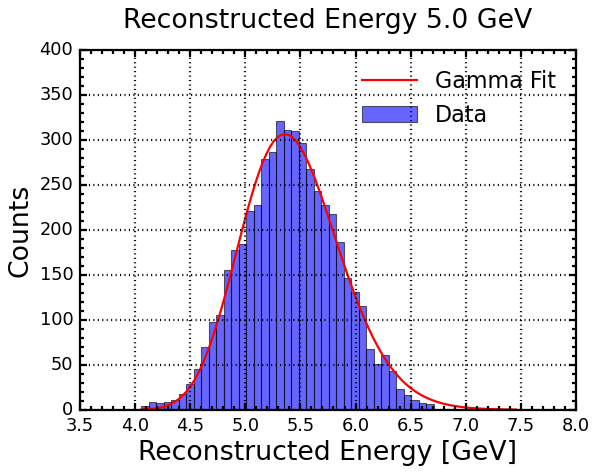

appending results for E = 5.0
Mean_Gamma: 5.439705824359915 Mean_Gamma_Error: 0.009931719375275039
Peak_Gamma: 5.358508575476153 Peak_Gamma_Error: 0.009800464664821231
Mean: 10.461004913115607, Peak: 10.671982765197754, RMS: 0.5978217423497528
Initial Gamma Fit Parameters: [np.float64(533.2624855041504), np.float64(4.912038837922193), np.float32(7.5244813), np.float64(0.5978217423497528)]
Gamma Fit Bounds: lower [np.float64(5.332624855041504), np.float64(-0.5087961162077808), np.float32(-0.24755186), np.float64(0.05978217423497528)], 
 upper [np.float64(3199.5749130249023), np.float64(49.12038837922193), np.float32(21.286722), np.float64(5.9782174234975285)]
Gamma Fit Parameters: [5.31212728e+02 4.91203884e+01 6.36125782e+00 8.44013344e-02]
Gamma Fit Peak: 10.422682816378398 ± 0.013022099210057494, Mean: 10.507084150818475 ± 0.013131503338675736, Resolution: 0.05675455040439429 ± 0.000863353835366664


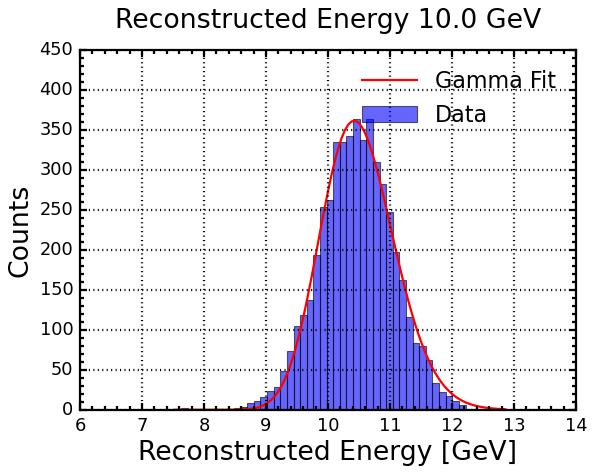

appending results for E = 10.0
Mean_Gamma: 10.507084150818475 Mean_Gamma_Error: 0.013131503338675736
Peak_Gamma: 10.422682816378398 Peak_Gamma_Error: 0.013022099210057494
Mean: 20.144654443494982, Peak: 20.148744583129883, RMS: 0.8080971691833329
Initial Gamma Fit Parameters: [np.float64(638.0218124389648), np.float64(3.866782511910536), np.float32(17.019918), np.float64(0.8080971691833329)]
Gamma Fit Bounds: lower [np.float64(6.380218124389649), np.float64(-0.6133217488089464), np.float32(0.7019919), np.float64(0.08080971691833329)], 
 upper [np.float64(3828.130874633789), np.float64(38.66782511910536), np.float32(35.529877), np.float64(8.080971691833328)]
Gamma Fit Parameters: [6.35965881e+02 3.86678251e+01 1.52135873e+01 1.28986650e-01]
Gamma Fit Peak: 20.07223390008593 ± 0.01766864542575076, Mean: 20.201220549752502 ± 0.017857735625857605, Resolution: 0.039959857071425284 ± 0.000615152945755139


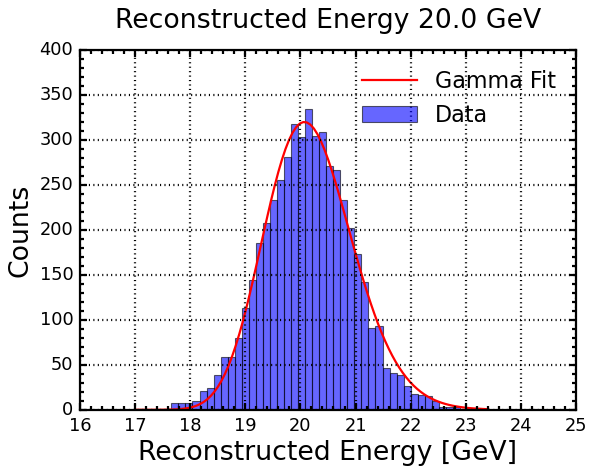

appending results for E = 20.0
Mean_Gamma: 20.201220549752502 Mean_Gamma_Error: 0.017857735625857605
Peak_Gamma: 20.07223390008593 Peak_Gamma_Error: 0.01766864542575076
Mean: 29.5520678662223, Peak: 29.340621948242188, RMS: 0.9951018317996821
Initial Gamma Fit Parameters: [np.float64(920.4170989990234), np.float64(5.303792890685683), np.float32(24.274254), np.float64(0.9951018317996821)]
Gamma Fit Bounds: lower [np.float64(9.204170989990235), np.float64(-0.46962071093143165), np.float32(1.4274254), np.float64(0.09951018317996822)], 
 upper [np.float64(5522.502593994141), np.float64(53.037928906856834), np.float32(46.41138), np.float64(9.951018317996821)]
Gamma Fit Parameters: [9.19717859e+02 5.30379289e+01 2.23631792e+01 1.36596239e-01]
Gamma Fit Peak: 29.471364635402956 ± 0.022589854927237276, Mean: 29.607960874670397 ± 0.022765747105678934, Resolution: 0.033754507462751125 ± 0.0005222257602898107


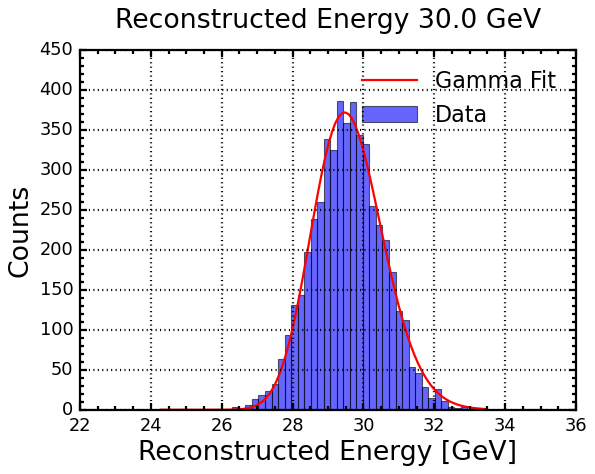

appending results for E = 30.0
Mean_Gamma: 29.607960874670397 Mean_Gamma_Error: 0.022765747105678934
Peak_Gamma: 29.471364635402956 Peak_Gamma_Error: 0.022589854927237276
Mean: 39.05939269466721, Peak: 39.14350509643555, RMS: 1.1413832204000438
Initial Gamma Fit Parameters: [np.float64(1077.7427673339844), np.float64(4.934792997655058), np.float32(33.426903), np.float64(1.1413832204000438)]
Gamma Fit Bounds: lower [np.float64(10.777427673339844), np.float64(-0.5065207002344942), np.float32(2.3426902), np.float64(0.11413832204000439)], 
 upper [np.float64(6466.456604003906), np.float64(49.34792997655058), np.float32(60.140354), np.float64(11.413832204000439)]
Gamma Fit Parameters: [1.07661270e+03 4.93479300e+01 3.11315499e+01 1.62395642e-01]
Gamma Fit Peak: 38.98304300630583 ± 0.024789846201218033, Mean: 39.14543864866684 ± 0.02499484386751092, Resolution: 0.02926396065591308 ± 0.00043456635214413736


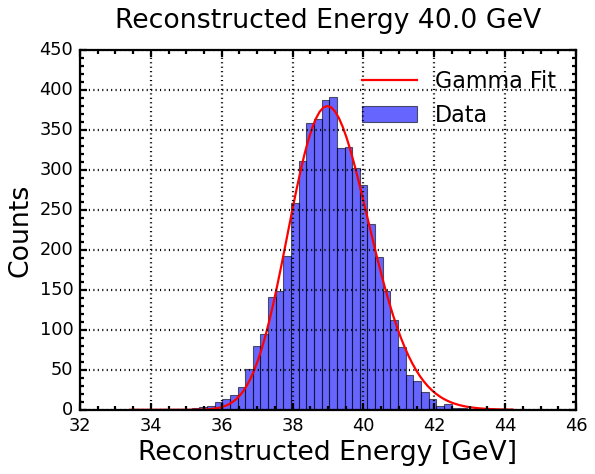

appending results for E = 40.0
Mean_Gamma: 39.14543864866684 Mean_Gamma_Error: 0.02499484386751092
Peak_Gamma: 38.98304300630583 Peak_Gamma_Error: 0.024789846201218033
Mean: 48.0822305681229, Peak: 48.336204528808594, RMS: 1.2250838712916121
Initial Gamma Fit Parameters: [np.float64(807.9057083129883), np.float64(3.288549140893766), np.float32(44.053482), np.float64(1.2250838712916121)]
Gamma Fit Bounds: lower [np.float64(8.079057083129882), np.float64(-0.6711450859106234), np.float32(3.4053483), np.float64(0.12250838712916122)], 
 upper [np.float64(4847.43424987793), np.float64(32.88549140893766), np.float32(76.08022), np.float64(12.25083871291612)]
Gamma Fit Parameters: [8.09270118e+02 3.28854914e+01 4.10114896e+01 2.17666116e-01]
Gamma Fit Peak: 47.951880656600466 ± 0.03756257824795649, Mean: 48.16954677262747 ± 0.03815575526868302, Resolution: 0.026030790153505397 ± 0.0005533253531585344


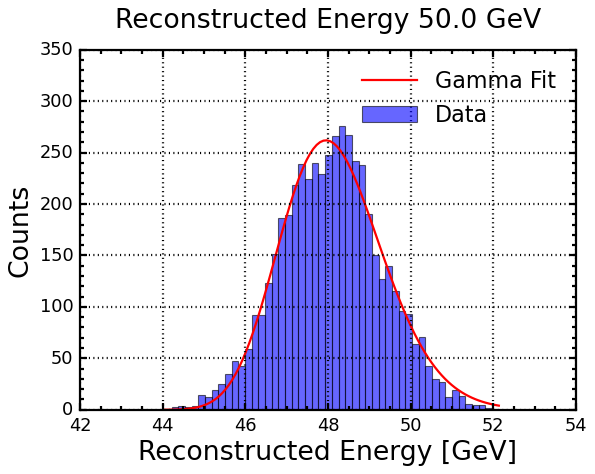

appending results for E = 50.0
Mean_Gamma: 48.16954677262747 Mean_Gamma_Error: 0.03815575526868302
Peak_Gamma: 47.951880656600466 Peak_Gamma_Error: 0.03756257824795649
Mean: 56.968672771079866, Peak: 56.86994171142578, RMS: 1.3494880782641474
Initial Gamma Fit Parameters: [np.float64(1091.2724533081055), np.float64(3.875387180625559), np.float32(51.738884), np.float64(1.3494880782641474)]
Gamma Fit Bounds: lower [np.float64(10.912724533081056), np.float64(-0.6124612819374441), np.float32(4.1738887), np.float64(0.13494880782641475)], 
 upper [np.float64(6547.634719848633), np.float64(38.75387180625559), np.float32(87.60832), np.float64(13.494880782641474)]
Gamma Fit Parameters: [1.08852891e+03 3.87538718e+01 4.86501086e+01 2.17243713e-01]
Gamma Fit Peak: 56.851899914214634 ± 0.03690816581553005, Mean: 57.069143627390055 ± 0.03730059523701758, Resolution: 0.02378810153816702 ± 0.00045069665256303247


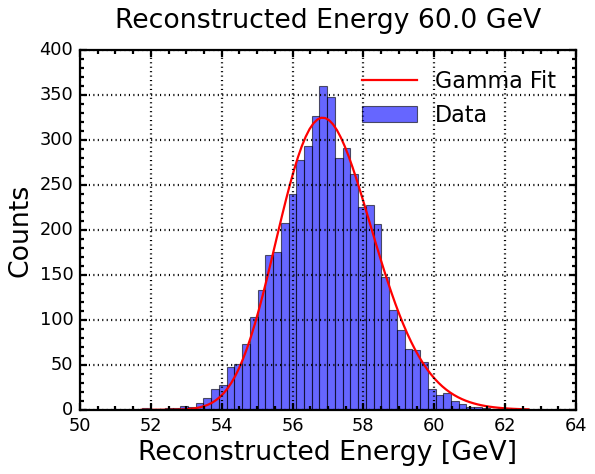

appending results for E = 60.0
Mean_Gamma: 57.069143627390055 Mean_Gamma_Error: 0.03730059523701758
Peak_Gamma: 56.851899914214634 Peak_Gamma_Error: 0.03690816581553005


In [24]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_DGCNN0_Fit.csv")
OutputCSV(Reco_hist_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")